# Introduction
The purpose of this analysis is to determine seasonal patterns and forecast trends in moving truck permitting in the City of Boston.

Data was obtained from [Boston's open data portal](https://data.boston.gov/dataset/open-moving-truck-permits).

This dataset was originally created to drive an interactive map, but the geospatial aspects are not explored here.

In [50]:
# libraries and settings
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from IPython.display import display
from fbprophet import Prophet
# suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
# display settings
pd.options.display.max_columns = None
%matplotlib inline

In [51]:
# read dataframe
# datatype specifications
mtDtypes = {'permitnumber': 'str', 'applicationmethod': 'str', 'applicant_city': 'str',
            'applicant_state': 'str', 'applicant_zip': 'str', 'total_fees': 'int64', 
            'city': 'str', 'zip': 'str'}
# restrict dataset to useful columns and set index.
mtdf = pd.read_csv('movingTruckData.csv', header=0,
                   parse_dates=['issued_date', 'expiration_date'],
                   index_col='permitnumber',
                   dtype=mtDtypes,
                   usecols=['permitnumber', 'applicationmethod', 'applicant_city', 'applicant_state',
                            'applicant_zip', 'total_fees', 'issued_date', 'expiration_date', 
                            'city', 'zip'])
display(mtdf.sample(5))

,applicationmethod,applicant_city,applicant_state,applicant_zip,total_fees,issued_date,expiration_date,city,zip
permitnumber,,,,,,,,,
OCCU-728781,InPersonPermit,BOSTON,MA,02113,69,2017-07-10 16:03:10,2017-07-19,South Boston,02127
OCCU-772692,InPersonPermit,Boston,MA,02201,69,2017-10-30 15:24:31,2017-11-03,Roxbury,02118
OCCU-488245,InPersonPermit,BRIGHTON,MA,02135,69,2015-06-25 12:26:53,2015-06-30,Roslindale,02131
OCCU-177499,InPersonPermit,BRIGHTON,MA,02135,109,2012-08-24 15:11:37,2012-08-29,Boston,02111
OCCU-270845,InPersonPermit,Boston,MA,02116,69,2013-08-06 12:06:24,2013-08-09,Boston,02215


The above dataframe still requires additional data quality checks:

In [52]:
# remove duplicate rows
mtdf = mtdf.loc[~mtdf.duplicated()]
# ensure consistent capitalization for city fields, remove extra whitespacpe
mtdf['applicant_city'] = mtdf['applicant_city'].str.title().str.strip()
mtdf['applicant_state'] = mtdf['applicant_state'].str.upper().str.strip()
# strip out any bad applicant zip codes, too many possibilities to attempt to fill blanks
az = mtdf['applicant_zip']
badAz = (az.str.len()!=5) | pd.isnull(az)
mtdf.loc[badAz, 'applicant_zip'] = None

In [53]:
# load Boston zip codes to map neighborhoods
zipNbh = pd.read_excel('zipNeighborhoods.xlsx',
                       converters={'zip': str, 'Neighborhood': str})
zipNbh.set_index('zip', inplace=True)
# alias boston zip codes as a series
bostonZips = zipNbh.index.to_series()

In [54]:
# fix zip codes that refer to location where moving truck will be parked in Boston
# try to fix any zips that are 4 characters, may just be missing a leading 0 or last digit, which is rather common.
problemZips = mtdf.loc[mtdf['zip'].str.len()==4, 'zip']
# find nearest zip code using startswith/endswith
nearestZips = problemZips.apply(lambda v: bostonZips.loc[(bostonZips.str.startswith(v) | bostonZips.str.endswith(v)).idxmax()])
# write nearest zip codes back
mtdf.loc[nearestZips.index, 'zip'] = nearestZips
# zip field should be within Boston
inBoston = mtdf['zip'].isin(bostonZips)
# if zip field is not in Boston, set to None
mtdf.loc[~inBoston, 'zip'] = None
# join with neighborhoods
mtdf['neighborhood'] = pd.merge(mtdf[['zip']], zipNbh, left_on='zip', right_index=True)['Neighborhood']
# fill null neighborhood values with "Boston"
mtdf['neighborhood'] = mtdf['neighborhood'].fillna('Boston')
print('Move counts by neighborhood, pre-cleanup:')
display(mtdf.groupby('neighborhood').size())

Move counts by neighborhood, pre-cleanup:


neighborhood
Allston                      3460
Boston                        474
Boston Back Bay             14771
Boston Beacon  Hill          4445
Boston Chinatown             1874
Boston Downtown Crossing     1136
Boston Fenway                6734
Boston Kenmore               4126
Boston North End             9133
Boston South End            11175
Boston West End              8402
Brighton                     6582
Brookline                       8
Charlestown                  5289
Dorchester                    394
Dorchester Center             399
Dorchester Grove Hall          98
Dorchester Uphams Corner     1146
East Boston                  1758
Hyde Park                      85
Jamaica Plain                5000
Mattapan                       32
Roslindale                    665
Roxbury                       414
Roxbury Mission Hill          642
South Boston                 8216
West Roxbury                  223
dtype: int64

In [55]:
# fix issue dates after expiration date
# if issue date is within 60 days of expiration date, use issued date for expiration, otherwise flag nan
daysAhead = (mtdf['expiration_date'] - mtdf['issued_date']).dt.days
# if permit appears to be issued more than 6M in advance, issue date is probably wrong
badIssue = (daysAhead <= -60) | (daysAhead > 180)
mtdf.loc[badIssue, ['expiration_date', 'issued_date']] = np.nan
okIssue = (daysAhead < 0) & (daysAhead > -60)
mtdf.loc[okIssue, 'expiration_date'] = mtdf.loc[okIssue, 'issued_date']
# recalc days ahead with fixed values, show stats
mtdf['days_ahead'] = (mtdf['expiration_date'] - mtdf['issued_date']).dt.days
display(mtdf['days_ahead'].describe())

count   96,498.00
mean         8.31
std          8.13
min          0.00
25%          3.00
50%          5.00
75%         11.00
max        178.00
Name: days_ahead, dtype: float64

In [56]:
# add calculated column w/r/t origin of move as a string variable
isBoston = mtdf['applicant_city'].isin(zipNbh['Neighborhood']) | mtdf['applicant_zip'].isin(bostonZips)
# mtdf['in_town'] = isBoston
inState = mtdf['applicant_state'] == 'MA'
moveType = pd.Series(index=mtdf.index, name='move_type')
moveType.loc[isBoston] = 'in-town'
moveType.loc[inState & ~inBoston] = 'out-of-town'
moveType.loc[~inState] = 'out-of-state'
moveType = moveType.fillna('unknown')
mtdf['move_type'] = moveType
display(moveType.describe())

count       96681
unique          4
top       in-town
freq        80984
Name: move_type, dtype: object

# Relationships Between Variables



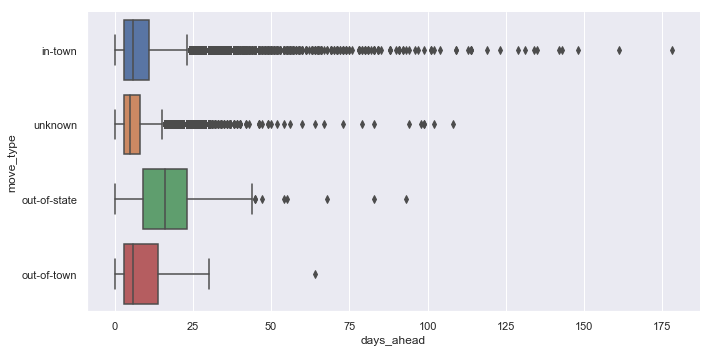

In [57]:
# filter to subset that has days ahead data
daysData = mtdf.loc[~mtdf['days_ahead'].isnull()]
# sns.catplot(x='move_type', y='days_ahead', hue='neighborhood', height=5, aspect=0.5, orient='h',
#             kind='box', data=daysData)
sns.catplot(y='move_type', x='days_ahead', orient='h', aspect=2,
            kind='box', data=daysData)

As one woudl expect, moves from applications outside the City of Boston, particularly from other states, are associated with systematically earlier permit filings, as represented by the median # of days ahead.
As this crosstab below shows, applicant address data quality leaves plenty to be desired, as demonstrated by the number of unknown move types.
All moves from MA residents who don't already reside in Boston were into Downtown or unknown neighborhoods.

In [58]:
print('Frequencies:')
display(pd.crosstab(mtdf['neighborhood'], mtdf['move_type']))

Frequencies:


move_type,in-town,out-of-state,out-of-town,unknown
neighborhood,,,,
Allston,2999,89,0,372
Boston,317,6,77,74
Boston Back Bay,11498,104,0,3169
Boston Beacon Hill,3487,23,0,935
Boston Chinatown,1537,14,0,323
Boston Downtown Crossing,982,4,0,150
Boston Fenway,5480,93,0,1161
Boston Kenmore,3479,73,0,574
Boston North End,8272,42,0,819


In [59]:
print('Move Type by Neighborhood:')
pd.options.display.float_format = lambda v: '{:.1f}%'.format(v*100)
ct = pd.crosstab(mtdf['move_type'], mtdf['neighborhood'])
display(ct / ct.sum(axis=0))
# reset float format
pd.options.display.float_format = '{:,.2f}'.format

Move Type by Neighborhood:


neighborhood,Allston,Boston,Boston Back Bay,Boston Beacon Hill,Boston Chinatown,Boston Downtown Crossing,Boston Fenway,Boston Kenmore,Boston North End,Boston South End,Boston West End,Brighton,Brookline,Charlestown,Dorchester,Dorchester Center,Dorchester Grove Hall,Dorchester Uphams Corner,East Boston,Hyde Park,Jamaica Plain,Mattapan,Roslindale,Roxbury,Roxbury Mission Hill,South Boston,West Roxbury
move_type,,,,,,,,,,,,,,,,,,,,,,,,,,,
in-town,86.7%,66.9%,77.8%,78.4%,82.0%,86.4%,81.4%,84.3%,90.6%,80.0%,86.1%,88.9%,87.5%,86.3%,84.5%,82.2%,80.6%,83.0%,85.5%,83.5%,86.0%,75.0%,80.0%,83.8%,80.7%,87.4%,76.7%
out-of-state,2.6%,1.3%,0.7%,0.5%,0.7%,0.4%,1.4%,1.8%,0.5%,0.8%,0.8%,1.4%,0.0%,0.4%,1.3%,1.0%,2.0%,1.0%,2.0%,0.0%,0.9%,0.0%,1.1%,1.4%,3.6%,0.9%,1.8%
out-of-town,0.0%,16.2%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
unknown,10.8%,15.6%,21.5%,21.0%,17.2%,13.2%,17.2%,13.9%,9.0%,19.2%,13.2%,9.7%,12.5%,13.3%,14.2%,16.8%,17.3%,16.1%,12.5%,16.5%,13.0%,25.0%,18.9%,14.7%,15.7%,11.7%,21.5%


On a percentage basis, Mission Hill and Allston show the highest percentage of out-of-state moving applications. This makes sense, because these are neighborhoods that attract significant numbers of students (at all levels).

# Time Series Seasonality and Prediction

move_date
2012-04-08     19
2012-04-15    103
2012-04-22    139
2012-04-29    152
2012-05-06    220
2012-05-13    130
2012-05-20    202
2012-05-27    267
2012-06-03    491
2012-06-10    223
dtype: int64

Text(0.5, 1.0, 'Overall Weekly Move Count')

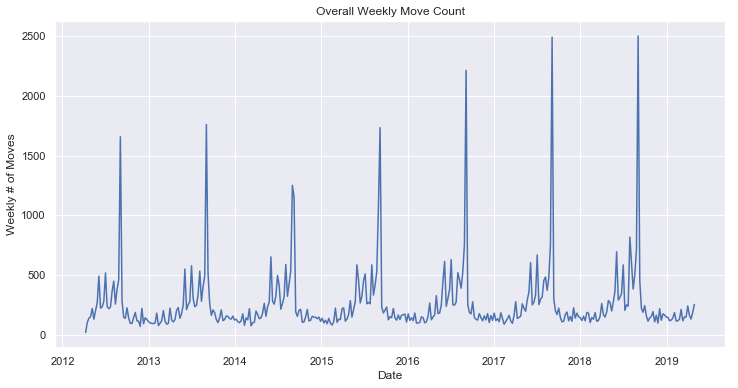

In [60]:
# proxy move date via permit expiration date-- 
#    typically, you don't keep a moving truck longer than you need.
# convert move dates to weeks
mtdf['move_date'] = mtdf['expiration_date'].dropna().dt.to_period('W').dt.to_timestamp('W')
mtdf['week_num'] = mtdf['move_date'].dt.week
# overall move count, preview time series
move_counts = mtdf.groupby('move_date').size()
# exclude moves that are in the future
move_counts = move_counts.loc[:'2019-04-30']
display(move_counts.head(10))
plt.plot(move_counts.index, move_counts.values)
plt.gcf().set_size_inches(12, 6)
plt.xlabel('Date')
plt.ylabel('Weekly # of Moves')
plt.title('Overall Weekly Move Count')

Overally weekly move count shows a strong seasonal pattern, with peaks on or around the key moving date of September 1 and smaller peaks around other month-end dates in the summer. 

Significantly fewer people apply for moving truck permits in the winter, possibly because snowbanks may make it difficult to park a moving truck.

### Log Transform
The extreme size of the September seasonal peak suggests that **log scaling** may be appropriate before fitting the FB Prophet model.

move_date
2012-04-08   1.28
2012-04-15   2.01
2012-04-22   2.14
2012-04-29   2.18
2012-05-06   2.34
2012-05-13   2.11
2012-05-20   2.31
2012-05-27   2.43
2012-06-03   2.69
2012-06-10   2.35
dtype: float64

Text(0.5, 1.0, 'Overall Weekly Move Count (log)')

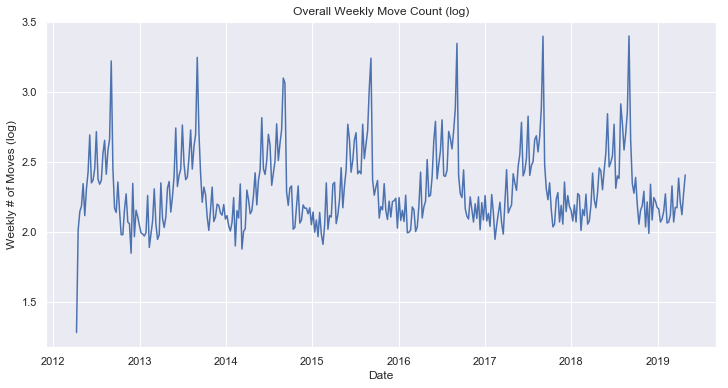

In [61]:
log_mc = np.log10(move_counts)
display(log_mc.head(10))
plt.plot(log_mc.index, log_mc.values)
plt.gcf().set_size_inches(12, 6)
plt.xlabel('Date')
plt.ylabel('Weekly # of Moves (log)')
plt.title('Overall Weekly Move Count (log)')

In [62]:
# move count time series by neighborhood


# fbprophet Forecasting
Because our move counts are aggregated by week, we can only forecast yearly seasonality.

In [63]:
# fbprophet forecasting
fbDf = log_mc.to_frame().reset_index()
fbDf.columns = ['ds', 'y']
# preview data for fitting
display(fbDf.head(10))
# use mc samples to get uncertainty in seasonality
m = Prophet(yearly_seasonality=True,
            weekly_seasonality=False,
            daily_seasonality=False,
            mcmc_samples=100)
m.fit(fbDf)

,ds,y
0,2012-04-08,1.28
1,2012-04-15,2.01
2,2012-04-22,2.14
3,2012-04-29,2.18
4,2012-05-06,2.34
5,2012-05-13,2.11
6,2012-05-20,2.31
7,2012-05-27,2.43
8,2012-06-03,2.69
9,2012-06-10,2.35


In [64]:
# predict one year of moves
future = m.make_future_dataframe(periods=52, freq='W')
display(future.tail(10))

,ds
411,2020-02-23
412,2020-03-01
413,2020-03-08
414,2020-03-15
415,2020-03-22
416,2020-03-29
417,2020-04-05
418,2020-04-12
419,2020-04-19
420,2020-04-26


In [65]:
forecast = m.predict(future)
display(forecast.tail(5))

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
416,2020-03-29,2.38,2.03,2.43,2.31,2.44,-0.17,-0.21,-0.12,-0.17,-0.21,-0.12,0.00,0.00,0.00,2.21
417,2020-04-05,2.38,2.06,2.45,2.31,2.45,-0.13,-0.17,-0.09,-0.13,-0.17,-0.09,0.00,0.00,0.00,2.25
418,2020-04-12,2.38,2.07,2.47,2.31,2.45,-0.11,-0.15,-0.07,-0.11,-0.15,-0.07,0.00,0.00,0.00,2.27
419,2020-04-19,2.38,2.07,2.48,2.31,2.45,-0.11,-0.15,-0.06,-0.11,-0.15,-0.06,0.00,0.00,0.00,2.27
420,2020-04-26,2.38,2.08,2.52,2.31,2.45,-0.08,-0.12,-0.05,-0.08,-0.12,-0.05,0.00,0.00,0.00,2.30


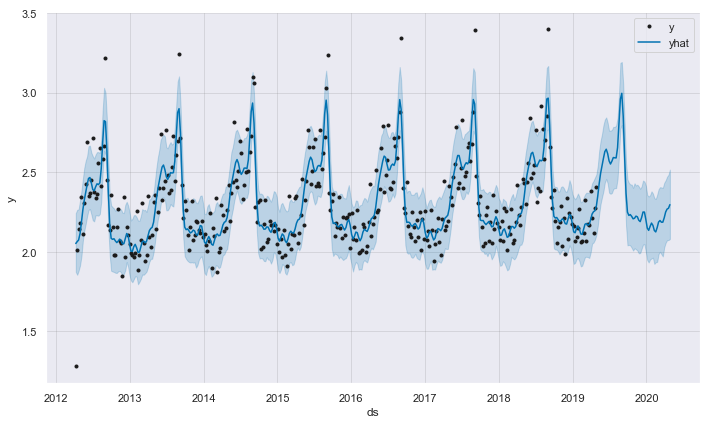

In [67]:
# plot forecast
fig = m.plot(forecast)
plt.legend()

In [70]:
# plot y vs yhat
# plt.scatter(forecast['y'], forecast['yhat'])

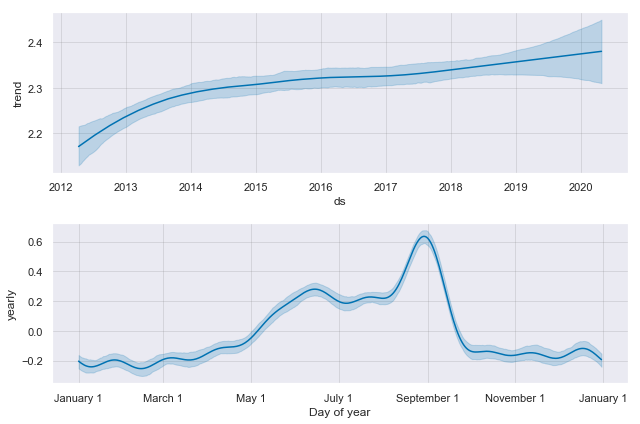

In [68]:
# plot forecast components
fig = m.plot_components(forecast)

### Component observations
The positive trend indicates that the number of weekly moving permits has increased on a secular basis. This may be an artifact of the way that data is entered into Boston's permitting database, or it may reflect population and economic growth.

The seasonality is strikingly sensible, from the perspective of someone who has ever lived in Boston-- September 1 is the main move day, with a smaller peak in June and a drastic reduction in moves over the winter.

In [ ]:
# TODO: include september 1 as a holiday called "Allston Christmas"
# TODO: more sensible train/test split